In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plant = 'Plant_1'
filename = 'Data/' + plant + '_wraped.csv'
df = pd.read_csv(filename)

In [3]:
mode_source_key = df['SOURCE_KEY'].mode().item()
df = df[df['SOURCE_KEY'] == mode_source_key]

/var/folders/nf/gc0__kh133b5ml5907fvy1xh0000gn/T/ipykernel_88536/3658023616.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = 'spearman')


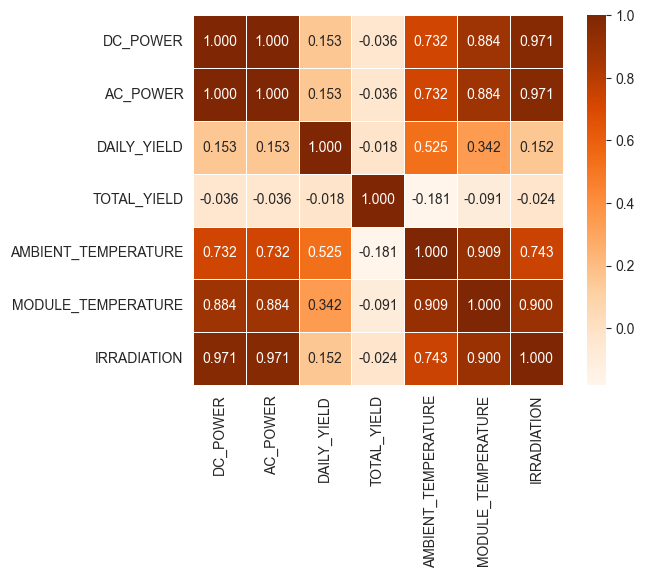

In [4]:
corr = df.corr(method = 'spearman')
plt.figure(dpi=100)
sns.heatmap(corr, robust=True, annot=True, fmt='0.3f', linewidths=.5, square=True, cmap='Oranges')
plt.show()

In [5]:
from pandas.tseries.offsets import DateOffset
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [6]:
pred_gen=df.copy()
pred_gen=pred_gen.groupby('DATE_TIME').sum()
pred_gen=pred_gen['DAILY_YIELD'][-288:].reset_index()
pred_gen.set_index('DATE_TIME',inplace=True)
pred_gen.head()

/var/folders/nf/gc0__kh133b5ml5907fvy1xh0000gn/T/ipykernel_88536/4201147790.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_gen=pred_gen.groupby('DATE_TIME').sum()


,DAILY_YIELD
DATE_TIME,
2020-06-14 23:30:00,3958.0
2020-06-14 23:45:00,1979.0
2020-06-15 00:00:00,0.0
2020-06-15 00:15:00,0.0
2020-06-15 00:30:00,0.0


In [7]:
result = adfuller(pred_gen['DAILY_YIELD'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.8280585223875117
p-value : 0.36662305631403697
#Lags Used : 1
Number of Observations Used : 286
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


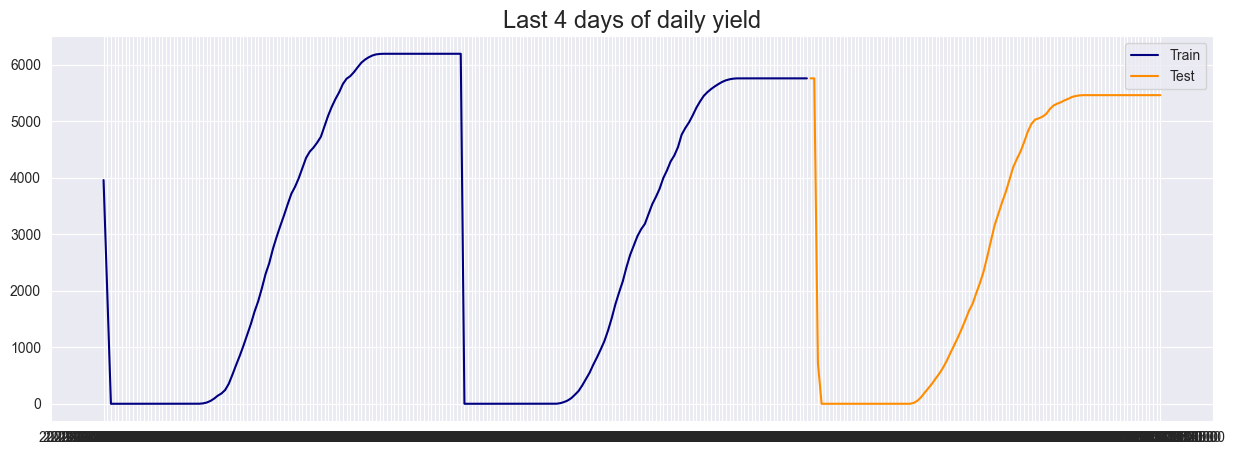

In [8]:
train=pred_gen[:192]
test=pred_gen[-96:]
plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of daily yield',fontsize=17)
plt.legend()
plt.show()

In [9]:
    arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=1443.949, Time=2.59 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=inf, Time=111.23 sec
 ARIMA(0,1,1)(0,1,1)[96]             : AIC=inf, Time=45.88 sec
 ARIMA(0,1,0)(1,1,0)[96]             : AIC=inf, Time=85.67 sec
 ARIMA(0,1,0)(0,1,1)[96]             : AIC=inf, Time=43.28 sec
 ARIMA(0,1,0)(1,1,1)[96]             : AIC=1441.338, Time=137.84 sec
 ARIMA(1,1,0)(1,1,1)[96]             : AIC=inf, Time=151.86 sec
 ARIMA(0,1,1)(1,1,1)[96]             : AIC=inf, Time=969.87 sec


/Users/renevelasquez/Desktop/python_projects/solar_power_generation/venv/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,1)(1,1,1)[96]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,1,1)(1,1,1)[96]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,1)[96] intercept   : AIC=1443.182, Time=147.30 sec

Best model:  ARIMA(0,1,0)(1,1,1)[96]          
Total fit time: 2577.255 seconds


In [11]:
future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

TypeError: can only concatenate str (not "DateOffset") to str